# Starting

We need to install a few libraries to start.

1. Create a new virtual environment

    - `python -m venv TEC_env`

2. Activate it:

    - `source TEC_env/bin/activate`

3. Install Requirements

    - `python -m pip install -r requirements.txt`

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import holoviews as hv
from holoviews import opts
import hvplot.pandas  # Required for visualization

hv.extension('bokeh')

# Optional: Set a nice theme for Seaborn
sns.set_theme(style="whitegrid")

# Create original data

In [2]:
# Replace with the path to your .xlsx file in Drive
file_path = 'TEC_survey_data.xlsx'

# Load the Excel file
df_start = pd.read_excel(file_path, sheet_name=2, header=1)

# Check original data

In [3]:
# Display columns name
print(df_start.columns)

# Display the first few rows
print(df_start.head())

Index(['Reference (tentative)', 'Journal',
       'System name (paper title tentative)', 'Publication year', 'paper DOI ',
       'Research institute', 'Country', 'Open Dataset (if yes: DOI)',
       'Integration Level', 'Infrastructure required', 'WiFi', 'BLE', 'UWB',
       'IMU', 'GNSS', 'Camera', 'Lidar', 'ILS training', 'Other techs', 'TRL',
       'Comments', 'outdoor/indoor', 'Environment description',
       'Environment type', 'tactile', 'audio', 'Feedback',
       'Human/Companion Robot', 'Interoperability', 'user training',
       'Usability', 'Usability description', 'Target users involved by design',
       'SHORT ABSTRACT', 'Accepted'],
      dtype='object')
   Reference (tentative)                                            Journal  \
0                    2.0  Journal of Information Technology Education: I...   
1                    3.0                                       MDPI Sensors   
2                    6.0                                       MDPI Sensors   
3  

# Preprocessing

In [4]:
df = df_start.copy()

In [5]:
# # Drop the first column
# df = df.drop(df.columns[0], axis=1)

print(len(df))

# Drop rows with NaN in a specific column
df = df.dropna(subset=['System name (paper title tentative)'])
print(len(df))

# Drop Accepted = no
df = df[df['Accepted'] != 'no']
print(len(df))

# Drop rows with Integration Level equals 'Survey'
df = df[df['Integration Level'] != 'Survey']
print(len(df))

84
78
77
74


In [6]:
df['Publication year'] = pd.to_numeric(df['Publication year'], errors='coerce')
df['Publication year'] = df['Publication year'].astype('Int64')

df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']] = df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']].replace({'yes': '1', 'no': '0'})
df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']] = df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']].apply(pd.to_numeric, errors='coerce').fillna(0)
df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']] = df[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']].astype(int)

df[['tactile', 'audio']] = df[['tactile', 'audio']].replace({'yes': '1', 'no': '0'})
df[['tactile', 'audio']] = df[['tactile', 'audio']].apply(pd.to_numeric, errors='coerce').fillna(0)
df[['tactile', 'audio']] = df[['tactile', 'audio']].astype(int)

df["Integration Level"] = df["Integration Level"].replace({"Prototipo sperimentale": "Experimental Prototype"})
df["Feedback"] = df["Feedback"].replace({"Audio + vibration": "Audio + Vibration"})

df['Infrastructure required'] = df['Infrastructure required'].replace({'yes': 'Yes', 'no': 'No'})
df['ILS training'] = df['ILS training'].replace({'yes': 'Yes', 'no': 'No'})
df['TRL'] = df['TRL'].replace({'low [1-3]': 'Low', 'medium [4-6]': 'Medium', 'high [7-10]': 'High'})
df['outdoor/indoor'] = df['outdoor/indoor'].replace({'indoor': 'Indoor', 'outdoor': 'Outdoor', 'both': 'Both', 'undefined': 'Undefined'})
df['Human/Companion Robot'] = df['Human/Companion Robot'].replace({'human': 'Human', 'companion': 'Companion', 'undefined': 'Undefined'})
df[['user training']] = df[['user training']].replace({'yes': 'Yes', 'no': 'No'})
df['Usability'] = df['Usability'].replace({'yes': 'Yes', 'no': 'No'})
df[['Target users involved by design']] = df[['Target users involved by design']].replace({'yes': 'Yes', 'no': 'No'})

df[['Infrastructure required', 'ILS training', 'TRL',
    'outdoor/indoor', 'Human/Companion Robot', 'user training',
    'Usability', 'Target users involved by design']] = df[['Infrastructure required', 'ILS training', 'TRL',
                                                            'outdoor/indoor', 'Human/Companion Robot', 'user training',
                                                            'Usability', 'Target users involved by design']].fillna('Undefined')

In [7]:
# Calculate the sum for each technology
df["tactile+audio"] = df['tactile'] + df['audio']
df["tactile+audio"] = df["tactile+audio"].replace({2:1,1:0})
df["no input"] = df['tactile'] + df['audio']
df["no input"] = df["no input"].replace({0:1,1:0,2:0})

# Substitute columns "tactile+audio", "tactile", "audio", "no input" with unique column "Input"
binary_columns = ["tactile+audio", "tactile", "audio", "no input"]
columns_to_keep = [col for col in df.columns if col not in binary_columns]
# Convert binary columns to a single categorical "Input" column
df["Input"] = df[binary_columns].idxmax(axis=1)
# Keep only the necessary columns
df = df[columns_to_keep + ["Input"]]
df['Input'] = df['Input'].replace({'tactile+audio': 'Tactile + Audio', 'tactile': 'Tactile', 'audio': 'Audio', 'no input': 'Undefined'})


In [8]:
# Take only 'yes' or 'no' from a text in column 'Open Dataset (if yes: DOI)
# separate by ',' and space
df['Open Dataset (if yes: DOI)'] = df['Open Dataset (if yes: DOI)'].str.split(',| ', n=1).str[0]
print(df['Open Dataset (if yes: DOI)'].unique())
# Raplace 'no' with 'No', others with 'Yes' and nan to 'NaN'
df['Open Dataset (if yes: DOI)'] = df['Open Dataset (if yes: DOI)'].replace({'no': 'No', 'yes': 'Yes', 'https://cocodataset.org/#home':'Yes', 'si':'Yes'})
df['Open Dataset (if yes: DOI)'] = df['Open Dataset (if yes: DOI)'].fillna('Undefined')
print(df['Open Dataset (if yes: DOI)'].unique())


['no' 'yes' 'Yes' 'https://cocodataset.org/#home' 'No']
['No' 'Yes']


In [9]:
# Define a dictionary to rename columns
rename_dict = {
    'Open Dataset (if yes: DOI)': 'Open Dataset',
    "Infrastructure required": "Infrastructure Required",
    "ILS training": "ILS Training",
    "outdoor/indoor": "Testing Environment",
    "Environment type": "Environment Type",
    "Human/Companion Robot": "Human-centered or Companion Robot",
    "Target users involved by design": "Target User Involved by Design",
    "user training": "User Training"
}
# Rename the columns using the dictionary
df.rename(columns=rename_dict, inplace=True)

## Check new data

In [10]:
print(df.columns)
print(df.head())

Index(['Reference (tentative)', 'Journal',
       'System name (paper title tentative)', 'Publication year', 'paper DOI ',
       'Research institute', 'Country', 'Open Dataset', 'Integration Level',
       'Infrastructure Required', 'WiFi', 'BLE', 'UWB', 'IMU', 'GNSS',
       'Camera', 'Lidar', 'ILS Training', 'Other techs', 'TRL', 'Comments',
       'Testing Environment', 'Environment description', 'Environment Type',
       'Feedback', 'Human-centered or Companion Robot', 'Interoperability',
       'User Training', 'Usability', 'Usability description',
       'Target User Involved by Design', 'SHORT ABSTRACT', 'Accepted',
       'Input'],
      dtype='object')
   Reference (tentative)                                            Journal  \
0                    2.0  Journal of Information Technology Education: I...   
1                    3.0                                       MDPI Sensors   
2                    6.0                                       MDPI Sensors   
3           

# Plots

## Open Dataset

Open Dataset
No     63
Yes    11
Name: count, dtype: int64


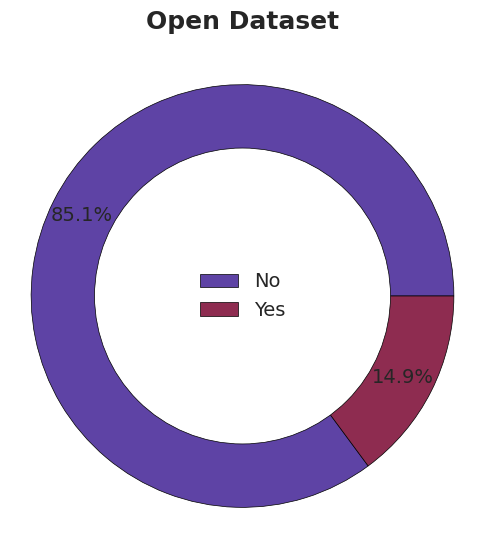

In [11]:
# Prepare the data for the pie chart
dataset_counts = df["Open Dataset"].value_counts()

# Define figure size
plt.figure(figsize=(6, 6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    dataset_counts,
    # labels=dataset_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(dataset_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Open Dataset\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=dataset_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/dataset_pie.pdf', bbox_inches='tight', dpi=300)

# Print
print(dataset_counts)

# Show the plot
plt.show()

## papers x years

/tmp/ipykernel_28241/739792372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Publication year', palette='twilight')


Publication year
2020    14
2021    15
2022    16
2023    24
2024     5
Name: count, dtype: Int64


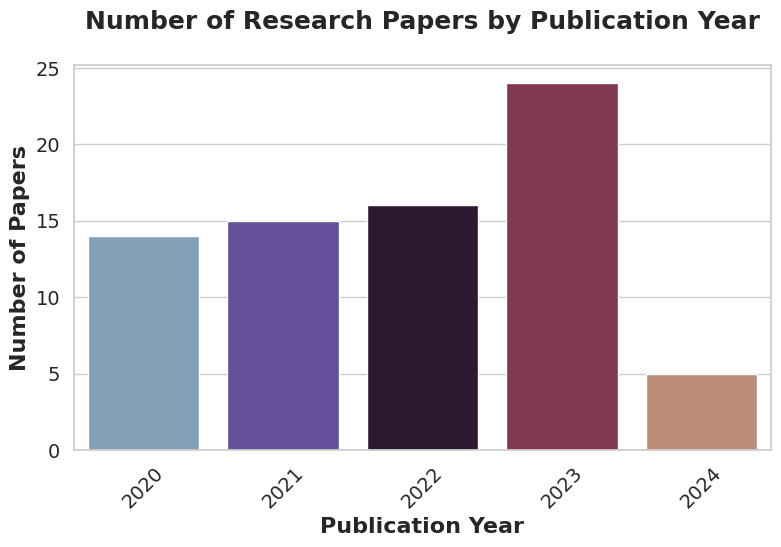

In [12]:
plt.figure(figsize=(9, 5))
sns.countplot(data=df, x='Publication year', palette='twilight')
plt.title("Number of Research Papers by Publication Year\n", fontsize=18, fontweight='bold')
plt.xlabel("Publication Year", fontsize=16, fontweight='semibold')
plt.ylabel("Number of Papers", fontsize=16, fontweight='semibold')
plt.xticks(rotation=45, fontsize=14)  # Rotate x-labels if needed
plt.yticks(fontsize=14)


# save in pdf
plt.savefig('plots/papers_x_years.pdf', bbox_inches='tight', dpi=300)

# Print papers x year
print(df['Publication year'].value_counts().sort_index())

plt.show()

## Integration Level

Integration Level
Commercial Device + Sensors    35
Commercial Device Only         22
Undefined                      10
Ad hoc Device                   4
Experimental Prototype          3
Name: count, dtype: int64


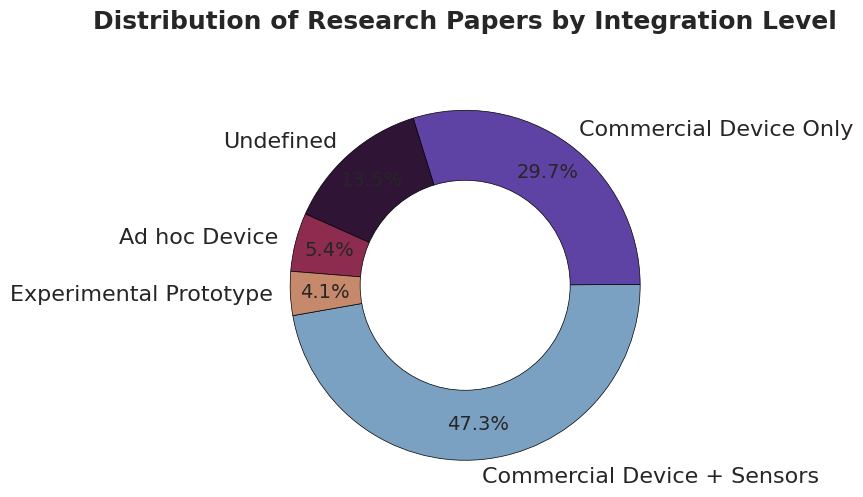

In [13]:
# Prepare the data for the pie chart
integration_counts = df["Integration Level"].value_counts()

# Define figure size
plt.figure(figsize=(9, 5))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    integration_counts,
    labels=integration_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=190,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(integration_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.8  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.6, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Distribution of Research Papers by Integration Level\n\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Save the figure
plt.savefig('plots/integration_level_pie.pdf', bbox_inches='tight', dpi=300)

# Print
print(integration_counts)

# Show the plot
plt.show()


/tmp/ipykernel_28241/4076116934.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="Integration Level", order=ordered_levels, palette='twilight')


Integration Level
Commercial Device + Sensors    35
Commercial Device Only         22
Undefined                      10
Ad hoc Device                   4
Experimental Prototype          3
Name: count, dtype: int64


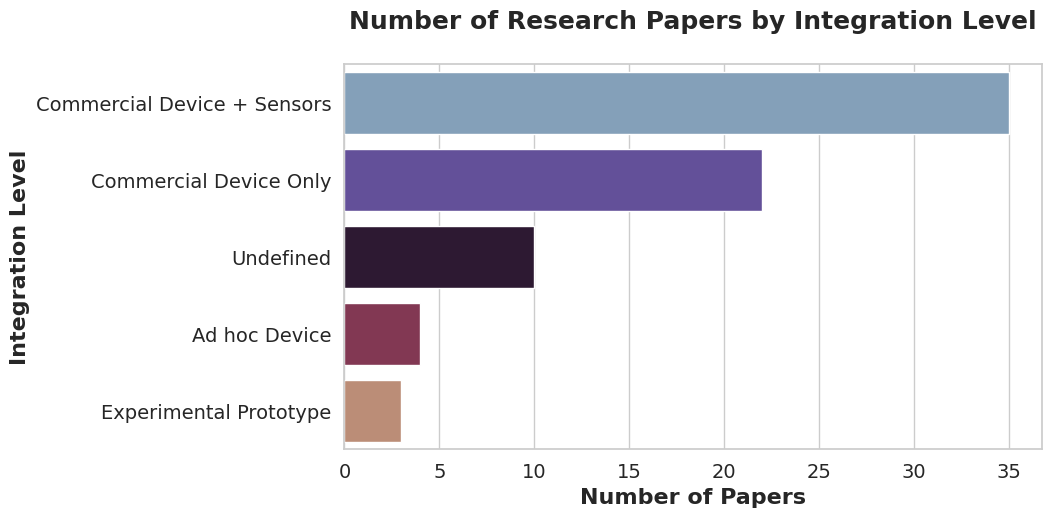

In [14]:
plt.figure(figsize=(9, 5))

# Get the sorted unique values in the order of count
ordered_levels = df["Integration Level"].value_counts().index.tolist()

# Create the countplot using the updated column
ax = sns.countplot(data=df, y="Integration Level", order=ordered_levels, palette='twilight')

plt.title("Number of Research Papers by Integration Level\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Papers", fontsize=16, fontweight='semibold')
plt.ylabel("Integration Level", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save in pdf
plt.savefig('plots/integration_level.pdf', bbox_inches='tight', dpi=300)

print(df["Integration Level"].value_counts())

plt.show()

## Infrastructure Required

Infrastructure Required
No     53
Yes    21
Name: count, dtype: int64


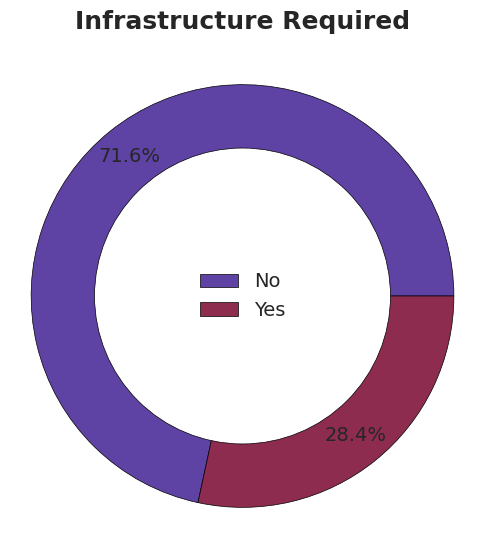

In [15]:
# Prepare the data for the pie chart
infrastructure_counts = df["Infrastructure Required"].value_counts()

# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    infrastructure_counts,
    # labels=infrastructure_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(infrastructure_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Infrastructure Required\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=infrastructure_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/infrastructure_required_pie.pdf', bbox_inches='tight', dpi=300)

print(infrastructure_counts)

# Show the plot
plt.show()

## TRL

TRL
Medium    45
Low       29
Name: count, dtype: int64


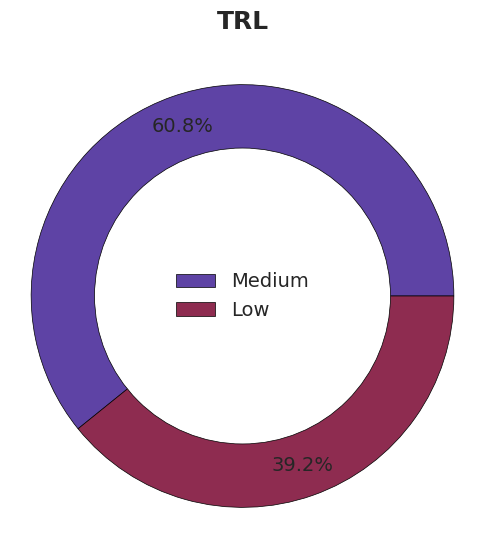

In [16]:
# Prepare the data for the pie chart
trl_counts = df["TRL"].value_counts()

# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    trl_counts,
    # labels=trl_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(trl_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("TRL\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend without border
plt.legend(labels=trl_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/trl_pie.pdf', bbox_inches='tight', dpi=300)

print(trl_counts)

# Show the plot
plt.show()

## ILS technologies

Testing Environment  Both  Indoor  Outdoor  Undefined  sum
UWB                     0       1        0          0    1
Lidar                   2       3        1          0    6
WiFi                    4       3        0          1    8
IMU                     2       6        1          1   10
BLE                     3       4        3          1   11
GNSS                   12       2        9          0   23
Camera                 17      17        8          4   46


<Figure size 900x500 with 0 Axes>

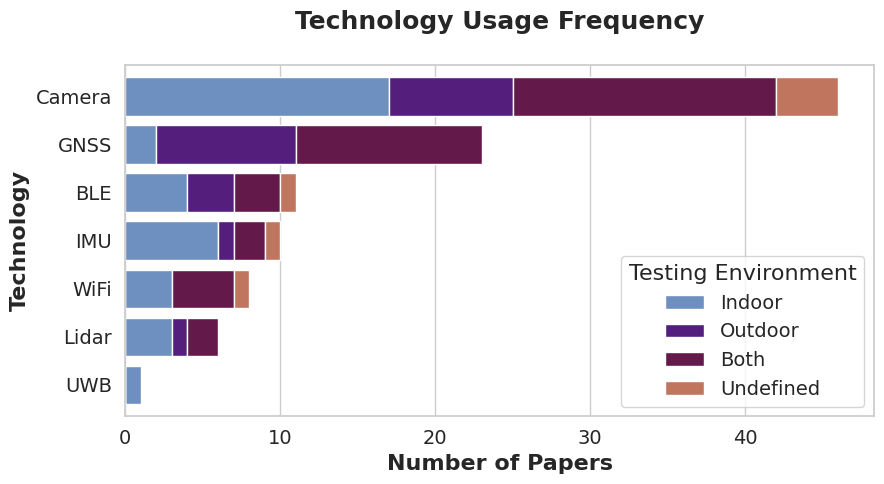

In [17]:
df_mini = df.copy()

df_mini = df_mini[['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar', 'Testing Environment']]

df_mini = df_mini.groupby('Testing Environment').sum()

plt.figure(figsize=(9, 5))
df_mini = df_mini.T
df_mini['sum'] = df_mini.sum(axis=1)

df_mini = df_mini.sort_values(by='sum', ascending=True)
df_mini[['Indoor', 'Outdoor', 'Both', 'Undefined']].plot(
    kind='barh', stacked=True, figsize=(9, 5),
    color=sns.color_palette('twilight', 4),
    width=0.8)

# Set white grid
plt.grid(axis='y', linestyle='', alpha=0.0)

plt.title("Technology Usage Frequency\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Papers", fontsize=16, fontweight='semibold')
plt.ylabel("Technology", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, title="Testing Environment", title_fontsize=16)
plt.tight_layout()

# save in pdf
plt.savefig('plots/ils_technologies.pdf', bbox_inches='tight', dpi=300)

print(df_mini)

plt.show()

## Number of papers x number of tech

/tmp/ipykernel_28241/801440357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tech_usage_counts.index, y=tech_usage_counts.values, palette='twilight')


   Number of Technologies  Number of Papers
0                       0                 9
1                       1                40
2                       2                15
3                       3                 5
4                       4                 5


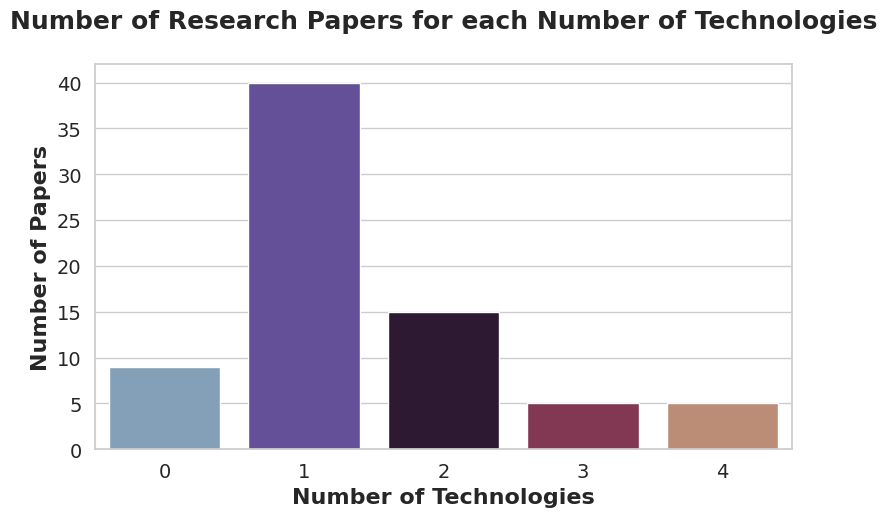

In [18]:
# Plot the number of papers for each number of thecnology used
tech_columns = ['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']
tech_usage_counts = df[tech_columns].sum(axis=1).value_counts().sort_index()

# plot with seaborn
plt.figure(figsize=(9, 5))
sns.barplot(x=tech_usage_counts.index, y=tech_usage_counts.values, palette='twilight')

plt.title("Number of Research Papers for each Number of Technologies\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Technologies", fontsize=16, fontweight='semibold')
plt.ylabel("Number of Papers", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save in pdf
plt.savefig('plots/papers_x_techs.pdf', bbox_inches='tight', dpi=300)

# Print
print(pd.DataFrame({
    'Number of Technologies': tech_usage_counts.index,
    'Number of Papers': tech_usage_counts.values
}))

plt.show()

## ILS Training

ILS Training
No     41
Yes    33
Name: count, dtype: int64


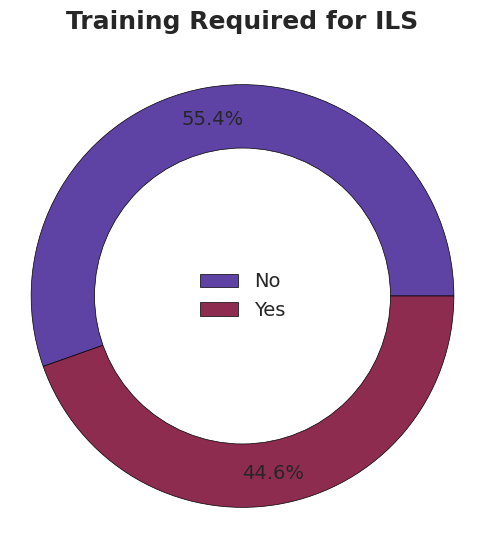

In [19]:
# Prepare the data for the pie chart
ils_training_counts = df["ILS Training"].value_counts()

# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    ils_training_counts,
    # labels=ils_training_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(ils_training_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Training Required for ILS\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=ils_training_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/ils_training_pie.pdf', bbox_inches='tight', dpi=300)

print(ils_training_counts)

# Show the plot
plt.show()

## Testing Environment

Testing Environment
Indoor       26
Both         25
Outdoor      14
Undefined     9
Name: count, dtype: int64


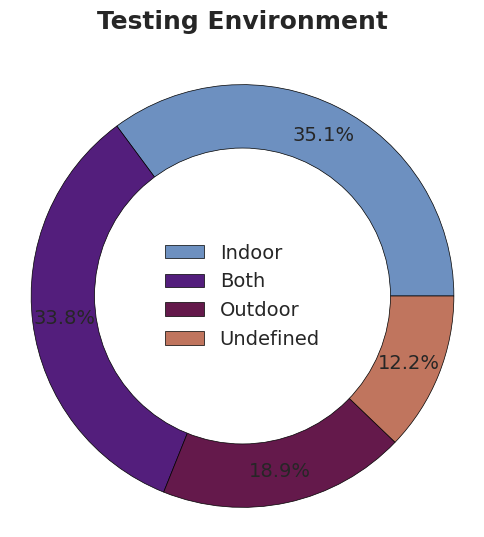

In [20]:
# Prepare the data for the pie chart
env_counts = df["Testing Environment"].value_counts()
# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    env_counts,
    # labels=env_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(env_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Testing Environment\n", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=env_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/testing_environment_pie.pdf', bbox_inches='tight', dpi=300)

print(env_counts)

# Show the plot
plt.show()

## Environment Type

/tmp/ipykernel_28241/2490152142.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="Environment Type", order=ordered_levels, palette='twilight')


Environment Type
Academic                    22
Simulative                  15
Real scenario               12
Infrastructure               8
Citizen                      7
Insufficient Information     4
Residential                  4
Name: count, dtype: int64


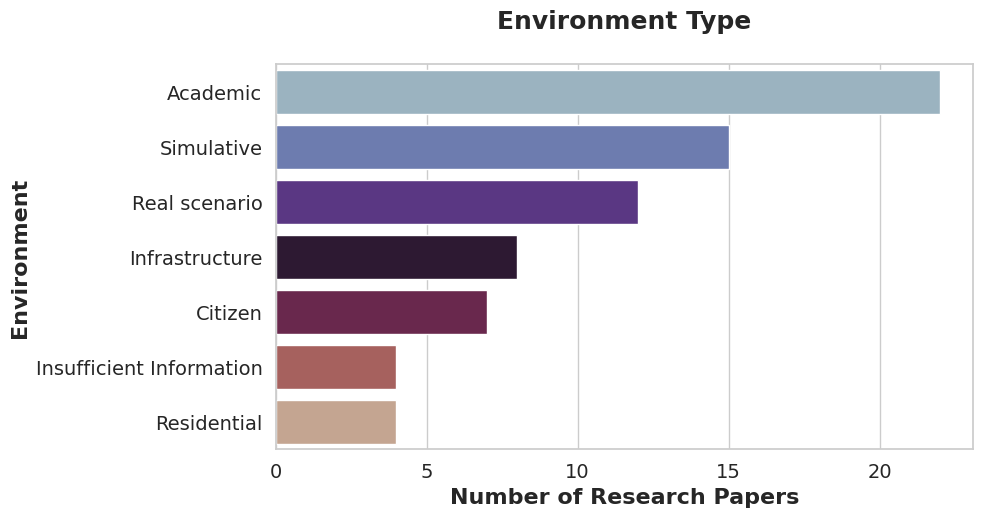

In [21]:
plt.figure(figsize=(9, 5))

# Get the sorted unique values in the order of count
ordered_levels = df["Environment Type"].value_counts().index.tolist()

# Create the countplot using the updated column
ax = sns.countplot(data=df, y="Environment Type", order=ordered_levels, palette='twilight')

plt.title("Environment Type\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Research Papers", fontsize=16, fontweight='semibold')
plt.ylabel("Environment", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save in pdf
plt.savefig('plots/environment_type.pdf', bbox_inches='tight', dpi=300)

print(df["Environment Type"].value_counts())

plt.show()

## User Inputs

/tmp/ipykernel_28241/3216793649.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="Input", order=ordered_levels, palette='twilight')


Input
Undefined          53
Tactile            11
Audio               9
Tactile + Audio     1
Name: count, dtype: int64


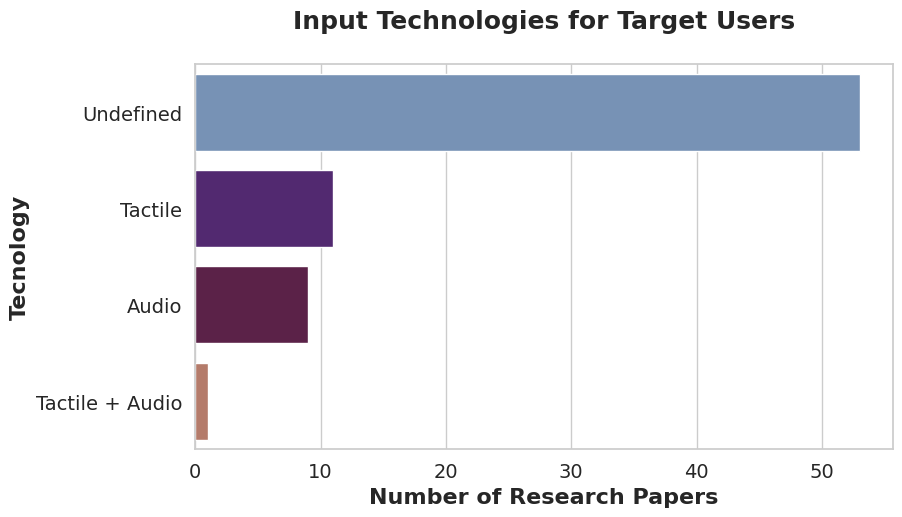

In [22]:
plt.figure(figsize=(9, 5))

# Get the sorted unique values in the order of count
ordered_levels = df["Input"].value_counts().index.tolist()

# Create the countplot using the updated column
ax = sns.countplot(data=df, y="Input", order=ordered_levels, palette='twilight')

plt.title("Input Technologies for Target Users\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Research Papers", fontsize=16, fontweight='semibold')
plt.ylabel("Tecnology", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save in pdf
plt.savefig('plots/user_input.pdf', bbox_inches='tight', dpi=300)

print(df["Input"].value_counts())

plt.show()

## User Feedback

/tmp/ipykernel_28241/2058916522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="Feedback", order=ordered_levels, palette='twilight')


Feedback
Audio                33
Undefined            15
Audio + Vibration    13
Audio + Haptic        6
Vibration             5
Haptic                1
Audio + Visual        1
Name: count, dtype: int64


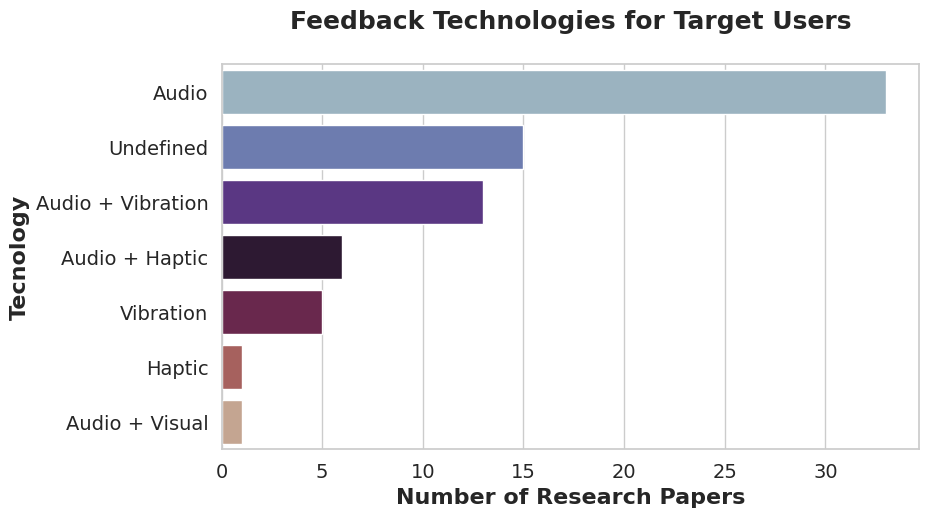

In [23]:
plt.figure(figsize=(9, 5))

# Get the sorted unique values in the order of count
ordered_levels = df["Feedback"].value_counts().index.tolist()

# Create the countplot using the updated column
ax = sns.countplot(data=df, y="Feedback", order=ordered_levels, palette='twilight')

plt.title("Feedback Technologies for Target Users\n", fontsize=18, fontweight='bold')
plt.xlabel("Number of Research Papers", fontsize=16, fontweight='semibold')
plt.ylabel("Tecnology", fontsize=16, fontweight='semibold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save in pdf
plt.savefig('plots/user_feedback.pdf', bbox_inches='tight', dpi=300)

print(df["Feedback"].value_counts())

plt.show()

## Human or Robot

Human-centered or Companion Robot
Human              63
Undefined           6
Human and Robot     5
Name: count, dtype: int64


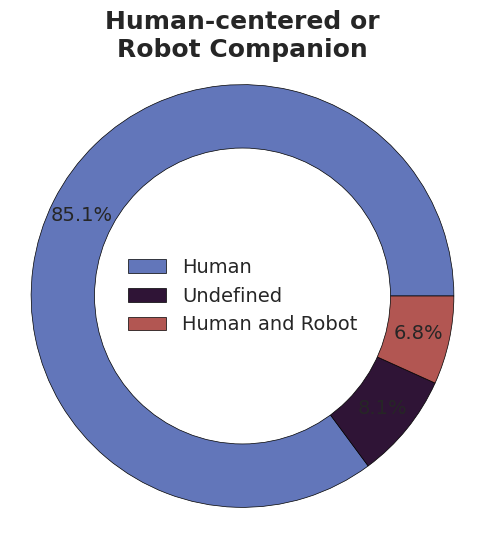

In [24]:
# Prepare the data for the pie chart
human_robot_counts = df["Human-centered or Companion Robot"].value_counts()
# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    human_robot_counts,
    # labels=human_robot_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(human_robot_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Human-centered or\nRobot Companion", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=human_robot_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/human_robot_pie.pdf', bbox_inches='tight', dpi=300)

print(human_robot_counts)

# Show the plot
plt.show()

## User training


User Training
Yes    38
No     36
Name: count, dtype: int64


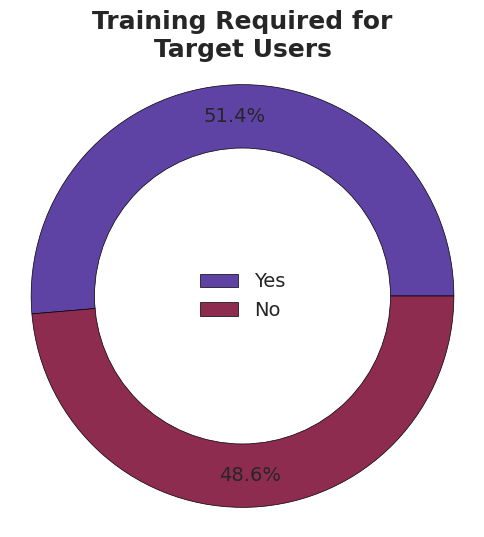

In [25]:
# Prepare the data for the pie chart
user_training_counts = df["User Training"].value_counts()
# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    user_training_counts,
    # labels=user_training.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(user_training_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Training Required for\nTarget Users", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=user_training_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/user_training_pie.pdf', bbox_inches='tight', dpi=300)

print(user_training_counts)

# Show the plot
plt.show()

## Usability

Usability
No     42
Yes    32
Name: count, dtype: int64


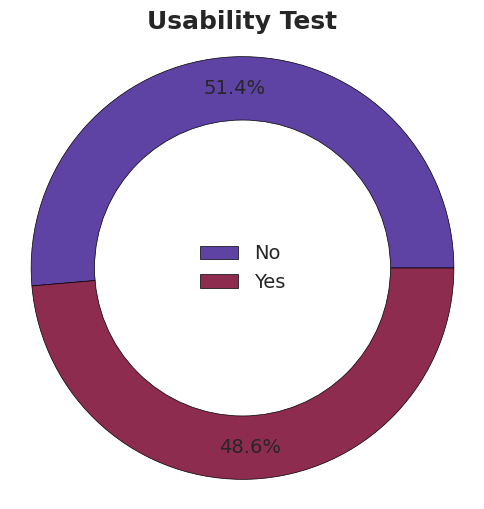

In [26]:
# Prepare the data for the pie chart
usability_counts = df["Usability"].value_counts()
# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    user_training_counts,
    # labels=user_training.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(usability_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Usability Test", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=usability_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/usability_pie.pdf', bbox_inches='tight', dpi=300)

print(usability_counts)

# Show the plot
plt.show()

## Users Involved by Design

Target User Involved by Design
No     46
Yes    28
Name: count, dtype: int64


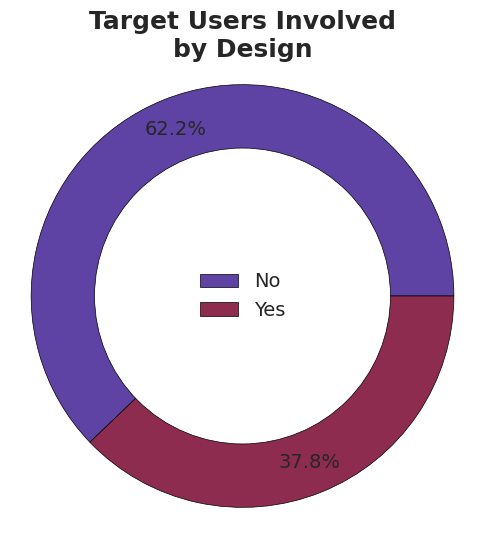

In [27]:
# Prepare the data for the pie chart
users_design_counts = df["Target User Involved by Design"].value_counts()
# Define figure size
plt.figure(figsize=(6,6))

# Create the donut chart (pie chart with a hole in the center) with internal borders
wedges, texts, autotexts = plt.pie(
    users_design_counts,
    # labels=users_design_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=0,  # Rotate for better layout
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Internal borders for each slice
    colors=sns.color_palette('twilight', len(users_design_counts)),  # Use Seaborn's pastel color palette
    pctdistance=0.85  # Adjust percentage text position
)

# Add a white circle in the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white', edgecolor='black', linewidth=0.5)  # Inner border added
plt.gca().add_artist(centre_circle)

# Apply the same title format as before
plt.title("Target Users Involved\nby Design", fontsize=18, fontweight='bold')

# Set font size for labels (category names)
for text in texts:
    text.set_fontsize(16)  # Adjust category label font size

# Set font size for percentages inside the slices
for autotext in autotexts:
    autotext.set_fontsize(14)  # Adjust percentage font size

# Ensure the chart remains circular
plt.axis('equal')

# Add Legend
plt.legend(labels=users_design_counts.index, loc='center', fontsize=14, frameon=False)

# Save the figure
plt.savefig('plots/users_design_pie.pdf', bbox_inches='tight', dpi=300)

print(users_design_counts)

# Show the plot
plt.show()

## Sankey Diagram

In [28]:
# Count occurrences of (Testing Environment → Environment Type)
df_counts = df.groupby(["Testing Environment", "Environment Type"]).size().reset_index(name="Count")

# Modify Environment Type labels to differentiate from Testing Environment
df_counts["Environment Type"] = "Environment Type: " + df_counts["Environment Type"]  # Prefix to prevent merging

# Create unique category list
categories = pd.unique(pd.concat([df_counts["Testing Environment"], df_counts["Environment Type"]])).tolist()

# Map categories to numerical indices
category_map = {category: i for i, category in enumerate(categories)}

# Convert Testing Environment and Environment Type to indices
df_counts["Testing Environment"] = df_counts["Testing Environment"].map(category_map)
df_counts["Environment Type"] = df_counts["Environment Type"].map(category_map)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=25,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=[c.replace("Environment Type: ", "") for c in categories],  # Remove prefix in display
        color=sns.color_palette('twilight', n_colors=len(categories)).as_hex()
    ),
    link=dict(
        source=df_counts["Testing Environment"],
        target=df_counts["Environment Type"],
        value=df_counts["Count"]
    )
))

# Customize layout
fig.update_layout(
    title=dict(
        text="Testing Environment → Environment Type",
        font=dict(size=28, family="Arial", color="black", weight="bold"),
        x=0.5,
        y=1.0
    ),
    font=dict(size=22, family="Arial", color="black"),
    autosize=False,
    width=900,
    height=500,
    margin=dict(l=5, r=5, t=80, b=20)  # Remove extra margins
)

# Save PDF
fig.write_image("plots/testing_environment_sankey.pdf", scale=4)

print(df_counts)

# Show the Sankey diagram
fig.show()


    Testing Environment  Environment Type  Count
0                     0                 4      5
1                     0                 5      2
2                     0                 6      2
3                     0                 7      1
4                     0                 8      4
5                     0                 9      2
6                     0                10      7
7                     1                 4     10
8                     1                 6      5
9                     1                 7      1
10                    1                 8      5
11                    1                 9      1
12                    1                10      4
13                    2                 4      6
14                    2                 5      4
15                    2                 6      1
16                    2                 8      2
17                    2                 9      1
18                    3                 4      1
19                  

In [29]:
# Count occurrences of (Input → Feedback)
df_counts = df.groupby(["Input", "Feedback"]).size().reset_index(name="Count")

# Modify Feedback labels to differentiate from Input
df_counts["Feedback"] = "Feedback: " + df_counts["Feedback"]  # Prefix to prevent merging

# Create unique category list
categories = pd.unique(pd.concat([df_counts["Input"], df_counts["Feedback"]])).tolist()

# Map categories to numerical indices
category_map = {category: i for i, category in enumerate(categories)}

# Convert Input and Feedback to indices
df_counts["Input"] = df_counts["Input"].map(category_map)
df_counts["Feedback"] = df_counts["Feedback"].map(category_map)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=25,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=[c.replace("Feedback: ", "") for c in categories],  # Remove prefix in display
        color=sns.color_palette('twilight', n_colors=len(categories)).as_hex()
    ),
    link=dict(
        source=df_counts["Input"],
        target=df_counts["Feedback"],
        value=df_counts["Count"]
    )
))

# Customize layout
fig.update_layout(
    title=dict(
        text="Input → Feedback for Target Users",
        font=dict(size=28, family="Arial", color="black", weight="bold"),
        x=0.5,
        y=1.0
    ),
    font=dict(size=22, family="Arial", color="black"),
    autosize=False,
    width=900,
    height=500,
    margin=dict(l=5, r=5, t=80, b=20)  # Remove extra margins
)

# Save PDF
fig.write_image("plots/input_feedback_sankey.pdf", scale=4)

In [30]:
# Count occurrences of (Input → User Training) and (User Training → Feedback)
df_counts_1 = df.groupby(["Input", "User Training"]).size().reset_index(name="Count")
df_counts_2 = df.groupby(["User Training", "Feedback"]).size().reset_index(name="Count")

# Add prefixes to differentiate nodes
df_counts_1["Input"] = "Input: " + df_counts_1["Input"]
df_counts_1["User Training"] = "Training: " + df_counts_1["User Training"]
df_counts_2["User Training"] = "Training: " + df_counts_2["User Training"]
df_counts_2["Feedback"] = "Feedback: " + df_counts_2["Feedback"]

# Create unique category list combining all three columns
categories = pd.unique(pd.concat([df_counts_1["Input"], df_counts_1["User Training"], df_counts_2["Feedback"]])).tolist()

# Map categories to numerical indices
category_map = {category: i for i, category in enumerate(categories)}

# Convert Input, User Training, and Feedback to numerical indices
df_counts_1["Input"] = df_counts_1["Input"].map(category_map)
df_counts_1["User Training"] = df_counts_1["User Training"].map(category_map)
df_counts_2["User Training"] = df_counts_2["User Training"].map(category_map)
df_counts_2["Feedback"] = df_counts_2["Feedback"].map(category_map)

# Combine the two dataframes to create source-target-value lists
source = df_counts_1["Input"].tolist() + df_counts_2["User Training"].tolist()
target = df_counts_1["User Training"].tolist() + df_counts_2["Feedback"].tolist()
values = df_counts_1["Count"].tolist() + df_counts_2["Count"].tolist()

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=25,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=[c.replace("Input: ", "").replace("Training: ", "").replace("Feedback: ", "") for c in categories],  # Clean display labels
        color=sns.color_palette('twilight', n_colors=len(categories)).as_hex()
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

# Customize layout
fig.update_layout(
    title=dict(
        text="Input → User Training Required → Feedback for Target Users",
        font=dict(size=28, family="Arial", color="black", weight="bold"),
        x=0.5,  # Center title
        y=0.95
    ),
    font=dict(size=22, family="Arial", color="black"),
    autosize=False,
    width=1100,
    height=600,
    margin=dict(l=5, r=5, t=80, b=20)  # Increase top margin to prevent overlap
)

# Save PDF
fig.write_image("plots/input_usertr_feedback_sankey.pdf", scale=4)

print(df_counts_1)
print(df_counts_2)

# Show the Sankey diagram
fig.show()


   Input  User Training  Count
0      0              4      7
1      0              5      2
2      1              4      3
3      1              5      8
4      2              5      1
5      3              4     26
6      3              5     27
    User Training  Feedback  Count
0               4         6     18
1               4         7      2
2               4         8      2
3               4         9      1
4               4        10      1
5               4        11      9
6               4        12      3
7               5         6     15
8               5         7      4
9               5         8     11
10              5        11      6
11              5        12      2


In [31]:
# Count occurrences of (Usability → Target User Involved by Design) and (Target User Involved by Design → User Training)
df_counts_1 = df.groupby(["Usability", "Target User Involved by Design"]).size().reset_index(name="Count")
df_counts_2 = df.groupby(["Target User Involved by Design", "User Training"]).size().reset_index(name="Count")

# Add prefixes to differentiate nodes
df_counts_1["Usability"] = "Usability: " + df_counts_1["Usability"]
df_counts_1["Target User Involved by Design"] = "Design: " + df_counts_1["Target User Involved by Design"]
df_counts_2["Target User Involved by Design"] = "Design: " + df_counts_2["Target User Involved by Design"]
df_counts_2["User Training"] = "Training: " + df_counts_2["User Training"]

# Create unique category list combining all three columns
categories = pd.unique(pd.concat([df_counts_1["Usability"], df_counts_1["Target User Involved by Design"], df_counts_2["User Training"]])).tolist()

# Map categories to numerical indices
category_map = {category: i for i, category in enumerate(categories)}

# Convert Usability, Target User Involved by Design, and User Training to numerical indices
df_counts_1["Usability"] = df_counts_1["Usability"].map(category_map)
df_counts_1["Target User Involved by Design"] = df_counts_1["Target User Involved by Design"].map(category_map)
df_counts_2["Target User Involved by Design"] = df_counts_2["Target User Involved by Design"].map(category_map)
df_counts_2["User Training"] = df_counts_2["User Training"].map(category_map)

# Combine the two dataframes to create source-target-value lists
source = df_counts_1["Usability"].tolist() + df_counts_2["Target User Involved by Design"].tolist()
target = df_counts_1["Target User Involved by Design"].tolist() + df_counts_2["User Training"].tolist()
values = df_counts_1["Count"].tolist() + df_counts_2["Count"].tolist()

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(pad=25,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=[c.replace("Usability: ", "").replace("Design: ", "").replace("Training: ", "") for c in categories],  # Clean display labels
        color=sns.color_palette('twilight', n_colors=len(categories)).as_hex()
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

# Customize layout
fig.update_layout(
    title=dict(
        text="Usability Test → Target User Involved by Design → Target User Training Required",
        font=dict(size=28, family="Arial", color="black", weight="bold"),
        x=0.5,  # Center title
        y=0.95
    ),
    font=dict(size=22, family="Arial", color="black"),
    autosize=False,
    width=1100,
    height=600,
    margin=dict(l=5, r=5, t=80, b=20)  # Increase top margin to prevent overlap
)

# Save PDF
fig.write_image("plots/usability_design_usertr_sankey.pdf", scale=4)

print(df_counts_1)
print(df_counts_2)

# Show the Sankey diagram
fig.show()


   Usability  Target User Involved by Design  Count
0          0                               2     37
1          0                               3      5
2          1                               2      9
3          1                               3     23
   Target User Involved by Design  User Training  Count
0                               2              4     26
1                               2              5     20
2                               3              4     10
3                               3              5     18


## Chord Diagram

In [32]:
# Define technology columns
tech_columns = ['WiFi', 'BLE', 'UWB', 'IMU', 'GNSS', 'Camera', 'Lidar']

# Compute co-occurrence matrix
co_occurrence_matrix = np.zeros((len(tech_columns), len(tech_columns)))

for i, tech1 in enumerate(tech_columns):
    for j, tech2 in enumerate(tech_columns):
        if i != j:  # Avoid self-loops
            co_occurrence_matrix[i, j] = ((df[tech1] == 1) & (df[tech2] == 1)).sum()

# Create list of connections (source, target, value)
links = []
for i, tech1 in enumerate(tech_columns):
    for j, tech2 in enumerate(tech_columns):
        if co_occurrence_matrix[i, j] > 0:  # Only add meaningful connections
            links.append((i, j, co_occurrence_matrix[i, j]))  # Use index values instead of names

# Convert links into a DataFrame
links_df = pd.DataFrame(links, columns=['source', 'target', 'value'])

# Create a DataFrame for nodes (mapping index to name)
nodes_df = pd.DataFrame({'index': range(len(tech_columns)), 'name': tech_columns})

# Convert to HoloViews Datasets
nodes_hv = hv.Dataset(nodes_df, 'index')
links_hv = hv.Dataset(links_df, ['source', 'target'], 'value')

# Hook function to modify title alignment
def center_title(plot, element):
    plot.state.title.align = "center"  # Forces the title to be centered

# Create Chord diagram with centered title
chord = hv.Chord((links_hv, nodes_hv)).opts(
    opts.Chord(
        cmap=sns.color_palette('twilight', n_colors=len(tech_columns)).as_hex(),
        edge_cmap=sns.color_palette('twilight', n_colors=len(tech_columns)).as_hex(),
        edge_color=hv.dim('source'),
        labels='name',
        node_color=hv.dim('index'),
        node_size=18,
        edge_line_width=2,
        edge_alpha=0.7,
        width=600,  # Increase width to ensure centering
        height=600,
        padding=0.1,  # Adds spacing to prevent overlap
        title="ILS Technology Co-occurrence",  # Title Text
        fontsize={'title': 15},  # Adjust Title Font Size
        hooks=[center_title]  # Hook function to force title alignment
    )
)

hv.save(chord, 'plots/ils_tech_chord.html', backend='bokeh')

# Print co-occurrence matrix
print(pd.DataFrame(co_occurrence_matrix, index=tech_columns, columns=tech_columns, dtype=int))

hv.output(chord)


        WiFi  BLE  UWB  IMU  GNSS  Camera  Lidar
WiFi       0    2    1    1     3       4      3
BLE        2    0    0    2     5       4      0
UWB        1    0    0    0     0       1      1
IMU        1    2    0    0     3       7      2
GNSS       3    5    0    3     0      13      3
Camera     4    4    1    7    13       0      5
Lidar      3    0    1    2     3       5      0


:Chord   [source,target]   (value)